## From Principal Component (PCA) to Direct Coupling Analysis (DCA) of Coevolution in Proteins

This notebook takes a look at a 2013 paper from Simona Cocco, Remi Monasson, Martin Weigt titled
**From Principal Component to Direct Coupling Analysis of Coevolution in Proteins: Low-Eigenvalue Modes are Needed for Structure Prediction.** *\[2013Cocco\]*

Link: https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003176

This paper looks at extracting functional and structural information from Multiple Sequence Alignments (MSA) of homologous proteins. First a covariance matrix of the residues are created from the MSA. Then the paper connects two approaches 

*  PCA - which identifies correlated groups of residues
*  DCA - which identifies residue-residue contacts

It shows how these two methods are related in non-intuitive ways using sophisticated statistical-physics models. This connection between the two approaches allows one to perform some sort of "dimension reduction" on DCA and to accurately predict residue-residue contacts with a smaller number of parameters. It also shows that the low eigenvalue values, which are discarded by PCA, are actually important to recover contact information. 

### Sections

1. [Multiple Sequence Alignment](#msa)
2. [Re-weighting Sequences](#reweight)
3. [Compute Single and Double Site marginals](#marginals)
4. [Compute the Covariance matrix](#covmat)
5. [Maximum Entropy Modeling and Direct Coupling Analysis](#maxent)  
6. [Approximations to DCA](#approxdca)
7. [PSICOV - Sparse inverse covariance estimation](#2011PSICOV)
8. [Correlation Matrix and connection to PCA](#pcaconnect)
9. [Results](#2013CoccoResults)
    - [Hopfield Potts model](#HopfieldPotts)
***


### Multiple Sequence Alignment (MSA)  <a id="msa"></a>

We use a [DHFR](https://www.uniprot.org/uniprot/P00374) alignment as an example to try out the methods of the papers. The alignment file is generated by [jackhmmer](https://www.ebi.ac.uk/Tools/hmmer/search/jackhmmer)


```
sp|P00374|DYR_HUMAN Dihydrofolate reductase OS=Homo sapiens OX=9606 GN=DHFR PE=1 SV=2
MVGSLNCIVAVSQNMGIGKNGDLPWPPLRNEFRYFQRMTTTSSVEGKQNLVIMGKKTWFS
IPEKNRPLKGRINLVLSRELKEPPQGAHFLSRSLDDALKLTEQPELANKVDMVWIVGGSS
VYKEAMNHPGHLKLFVTRIMQDFESDTFFPEIDLEKYKLLPEYPGVLSDVQEEKGIKYKF
EVYEKND
```

Note: Not exactly sure how the alignment is generated. 

```shell
jackhmmer -A DHFR_uniref90.aln --noali --notextw P00374.fasta uniref90.fasta
# some filtering script
```

In [1]:
import os
import itertools
import numpy as np
import scipy
import scipy.linalg

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
datadir = "../data"
msa_file = os.path.join(datadir, "DHFR.aln")

# Read all the lines in the file into a 2D array of type S1
with open(msa_file) as fh:
    arr = np.array([[x for x in line.strip()] for line in fh], np.dtype("S1"))

print("shape =", arr.shape, ",dtype= ", arr.dtype)

shape = (56165, 186) ,dtype=  |S1


In [3]:
# M is the number of sequences
# L is the length
M, L = arr.shape
print("Number of sequences : {} ".format(M))
print("Sequence Length : {}".format(L))

Number of sequences : 56165 
Sequence Length : 186


In [4]:
# the first sequence
arr[0, :].tostring()

b'VRPLNCIVAVSQNMGIGKNGDLPWPPLRNEFKYFQRMTTTSSVEGKQNLVIMGRKTWFSIPEKNRPLKDRINIVLSRELKEPPRGAHFLAKSLDDALRLIEQPELASKVDMVWIVGGSSVYQEAMNQPGHLRLFVTRIMQEFESDTFFPEIDLGKYKLLPEYPGVLSEVQEEKGIKYKFEVYEKKD'

In [5]:
# the second sequence
arr[1, :].tostring()

b'----SIVVVMCKRFGIGRNGVLPWSPLQADMQRFRSITAG-------GGVIMGRTTFDSIPEEHRPLQGRLNVVLTTSADLMKNSNIIFVSSFDELDAIVGL----HDHLPWHVIGGVSVYQHFLEKSQVTSMYVTFVDGSLECDTFFPHQFLSHFEITRA---SALMSDTTSGMSYRFVDYTR--'

We can order the amino acids any way we like. Here is a sorting based on some amino acid properties. 
https://proteinstructures.com/Structure/Structure/amino-acids.html

In [6]:
AMINO_ACIDS = np.array([aa for aa in "RKDEQNHSTCYWAILMFVPG-"], "S1")

### Compute the weights of each sequence <a id="reweight"></a>

To compute the weight of a sequence, we first compute the hamming distance between this sequence and all the other sequences in the alignment. Then we count the number of these distances that are less than a cutoff. 

This count is 1 for isolated sequences. It is large for sequences that have many similar sequences in the alignment. The weight is reciprocal of the count. So it is 1 for isolated sequences and close to zero for sequences that have many similar sequences in the MSA. (Eqn 27 in 2013Cocco)

$$w_m = \frac{1}{ \| \{ n | 1 \leq n \leq M  ; d_H [ (a_1^n, \ldots, a_L^n), (a_1^m, \ldots, a_L^m) ] \leq xL \} \| }$$



In [7]:
hamming_cutoff = 0.2 # This is x in the equation above
def compute_weight(index, x=hamming_cutoff, arr=arr):
    hamming_distances = np.sum(arr[index, :] != arr, axis=1)
    count = np.sum(hamming_distances <= x * arr.shape[1]) # L = arr.shape[1]
    return (1.0 / count)

# compute the weight of the first sequence
compute_weight(0)

0.005681818181818182

In [8]:
progress_bar = True
try:
    from IPython.display import clear_output
except ImportError:
     progress_bar = False

weights_file = os.path.join(datadir, "DHFR.weights.npy")

if os.path.isfile(weights_file):
    weights = np.load(weights_file)
    print("Loading weights from : ", weights_file)

else:
    weights = np.zeros(M, dtype=np.float64)

    for i in range(M):
        weights[i] = compute_weight(i)
        if i % 100 == 0:
            if progress_bar:
                clear_output(wait=True)
            print ("Processing sequence", i, "of", M)
    np.save(weights_file, weights)
    print("Finished computing sequence weights and saved to : ", weights_file)


Loading weights from :  ../data/DHFR.weights.npy


In [9]:
# number of effective sequences
M_eff = sum(weights) # Eqn 28 in 2013Cocco
print(int(round(M_eff)))

15238


In [10]:
# q is the alphabet
q = len(AMINO_ACIDS)
pseudo_count = round(M_eff)

### Compute Weighted Single and Double site marginals <a id="marginals"></a>

We first compute the weighted counts for the single site marginals $$\sum_{m=1}^M w_m \delta_{a, a_i^m},$$ and then we compute the weighted counts for the double site marginals $$\sum_{m=1}^M w_m \delta_{a, a_i^m} \delta_{b, a_j^m}.$$ The second computation takes a long time since the arrays are too large to compute outer products and broadcast them. 

To get the actual marignals we need to divide these weighted counts above by the sum of the weights. However, we only do this after adding a pseudocount to regularize the resulting covariance matrix. (Eqns 29 and 30 in 2013Cocco.)


In [11]:
single_site_marginal_file = os.path.join(datadir, "DHFR.single.npy")
double_site_marginal_file = os.path.join(datadir, "DHFR.double.npy")

if os.path.isfile(double_site_marginal_file) and os.path.isfile(single_site_marginal_file):
    f_i_a = np.load(single_site_marginal_file)
    print("Loading single site marginals from ", single_site_marginal_file)

    f_i_j_a_b = np.load(double_site_marginal_file)
    print("Loading double site marginals from ", double_site_marginal_file)    

else:
    # We first compute a one-hot matrix of shape (M, L, q)
    # which is 0/1 in index (m, i, a) depending on whether 
    # Protein *m* has amino acid *a* in position *i* 
    arr_onehot = np.zeros(arr.shape + (q,), dtype=np.uint8)
    for i, a in enumerate(AMINO_ACIDS):
        arr_onehot[..., i] = (arr == a)
    print("arr_onehot.shape = {}".format(arr_onehot.shape))
    
    # we reorder the one-hot axes so that the sequences are in the last dimension
    # this allows us to multiply easily by the weights using broadcasting
    arr_onehot_reorder = np.moveaxis(arr_onehot, 0, 2)
    weighted_arr_onehot = arr_onehot_reorder * weights

    
    # Set up the weighted double site marginals array
    f_i_j_a_b = np.zeros((L, q, L, q), dtype=weights.dtype)
    
    # we cannot use outer products here because our arrays are too big
    # So we iterate
    for j, b in itertools.product(range(L), range(q)):
        f_i_j_a_b[:, :, j, b] = np.sum((weighted_arr_onehot * arr_onehot_reorder[j, b, :]), axis=-1)
        if progress_bar:
            clear_output(wait=True)
        print("Finished processing j={}, b={}, AA={}".format(j, b, AMINO_ACIDS[b].tostring().decode()))

    # Weighted Single Site Marignals
    f_i_a = np.sum((arr_onehot_reorder * weights), axis=-1)
    print("f_i_a.shape = {}".format(f_i_a.shape)) 

    
    np.save(single_site_marginal_file, f_i_a)
    np.save(double_site_marginal_file, f_i_j_a_b)
    
    # delete large temporary arrays
    del weighted_arr_onehot, arr_onehot_reorder, arr_onehot
    print("Finished computing single and double site marginals and saved to cache files")

Loading single site marginals from  ../data/DHFR.single.npy
Loading double site marginals from  ../data/DHFR.double.npy


In [12]:
# Add Pseudo count and compute the marginals (Eqn 29 and 30 2013Cocco)
pseudo_count_ratio = float(pseudo_count) / (M_eff + pseudo_count)
f_i_a = (pseudo_count_ratio / q ) + (1 - pseudo_count_ratio) * f_i_a / M_eff
f_i_j_a_b = (pseudo_count_ratio  / (q*q) ) + (1 - pseudo_count_ratio) * f_i_j_a_b / M_eff


# The formula for f_i_j_a_b is a little different when i==j
# essentially we have f_i_a on the diagonal and zero's everywhere else. 
site_identity_mask = np.identity(q, dtype=bool)
for i in range(L):
    f_i_j_a_b[i, :, i, :] = np.diag(f_i_a[i, :])

### Compute the covariance matrix <a id="covmat"></a>



In [13]:
# Covariance Matrix
# We take an outer product of f_i_a with itself using numpy's broadcasting rules. 
# This gives us a matrix where the (i,a, j, b) index is f[i,a] * f[j,b]
C_i_j_a_b = f_i_j_a_b  - f_i_a[:, :, np.newaxis, np.newaxis] * f_i_a[np.newaxis, np.newaxis, :, :] 

# we project the covariance matrix down the first q-1 elements
# Since the frequencies add up to 1 we can discard amino-acid value (a = q) for each site
# without losing any information
C_i_j_a_b = C_i_j_a_b[:, :(q-1), :, :(q-1)]
print("C_i_j_a_b.shape = {}".format(C_i_j_a_b.shape)) 

# delete the frequency matrices now that we have a covariance matrix.
del f_i_a, f_i_j_a_b

C_i_j_a_b.shape = (186, 20, 186, 20)


### Maximum Entropy Modeling and Direct Coupling Analysis<a id="maxent"></a>

It is hard to infer contact information from this covariance matrix as a non-zero covariance between two sites does not imply that they directly interact or are in contact. If we have site $i$ interacting  with $j$ and site $j$ interacting with $k$, then $i$ and $k$ will show correlations even though they do not directly interact. 

So we decide to look for a (protein family specific) probability model $\bf P$ on the level of sequences that satisfies three conditions. 
1. The single site marginals of $\bf P$ are equal to $f_i(a)$.   
In other words, the sum of probabilities of all proteins with a in the $i$-th position is equal to the value of $f_i(a)$.
2. The double site marginals of $\bf P$ are equal to $f_{ij}(a,b)$.  
In other words, the sum of probabilities of all proteins with $a$ in the $i$-th position and $b$ in the $j$-th position is equal to $f_{ij}(a,b)$.
3. $\bf P$ has the **maximum possible entropy** so we maximize
$$ H[{\bf P}] = - \sum_{\text{all sequences of length L}} P \log P$$

Condition 1 gives us $Lq$ constraints and Condition 2 gives us $\frac{L(L-1)}{2} q^2$ additional constraints. This allows us to do a gigantic constrained optimization using Lagrange Multipliers and come up with an analytic form for $\bf P$.
$$ P(a_1, \ldots, a_L) = \frac{1}{Z} \exp{ \bigg\{ \frac{1}{2} \sum_{i,j} e_{ij}(a_i, a_j) + \sum_{i} h_i(a_i) \bigg\} }$$

Here $Z$ is a normalization constant that makes sure that all the probabilities add up to $1$. The parameters $e_{ij}(a,b)$ are the direct couplings and $h_i(a)$ are the local fields acting on single sites. These values have to be determined so that Conditions 1 and 2 are satisfied. 

It is not possible to compute these parameters exactly for reasonably sized proteins as calculating $Z$ and the marginals require summations over all $q^L$ possible amino-acid sequences. 


We can also view the Maximum Entropy model via its dual Maximum Likelihood problem. i.e. Assume that $P$ has the form above and maximize $$\mathcal{L} \big[ \{e_{ij}(a,b), h_i(a) \} \big\lvert \text{MSA} \big] = \frac{1}{M} \sum_{m=1}^{M} \log P(a_1^M, \ldots, a_L^m)$$ 



### Approximations to DCA <a id="dcaapprox"></a>
There are [several approximations](https://en.wikipedia.org/wiki/Direct_coupling_analysis) to estimate the parameters above

* Boltzmann Machine Learning (BM)
* Message passing / belief propagation (mpDCA)
* Mean Field Approximation (mfDCA)
* Gaussian Approximation (gaussDCA)
* Pseudolikelihoods Maximization (PLM)
* Adaptive Cluster Expansion (ACE)

### Mean Field Approximation <a id="meanfield"></a>
This is an approximation in statistical physics to help solve this intractable problem. We expand the exponential of the sum of the direct couplings using a Taylor Series expansion and then only keep the linear terms. With this approximation the values for the direct couplings are $$e_{ij}(a,b) = (C^{-1})_{ij}(a,b) \qquad \forall i,j, \enspace \forall a,b=1, \ldots, q-1$$ and $$e_{ij}(a,q) = e_{ij}(q,a) = 0 \qquad \forall a = 1, \ldots, q,$$ and $$ h_i(q) = 0.$$

This approximation approach is known as **mean field direct coupling analysis (mfDCA)**. Once the direct couplings have been calculated, they can be used to predict contacts between residues. This post processing prediction step will be covered later. 

In [14]:
# Our Covariance matrix is now invertible
cov = C_i_j_a_b.reshape((L*(q-1), L*(q-1)))
eigvals = np.linalg.eigvalsh(cov)

print("Number of eigenvalues: {}".format(eigvals.size))
print("Number of eigenvalues non-positive: {}".format(np.sum(eigvals <= 0)))

Number of eigenvalues: 3720
Number of eigenvalues non-positive: 0


### PSICOV - Sparse inverse covariance estimation <a id="2011PSICOV"></a>

The 2011 paper *PSICOV - precise structural contact prediction using sparse inverse covariance estimation* (**2011PSICOV**) deals with extracting information directly by inverting the unprojected covariance matrix $C_{ij}(a, b)$. 

This inversion gives a matrix $\Theta$ of partial correlations (i.e correlation between two sites controlling for the effect of all other sites). The covariance matrix is singular and so **2011PSICOV** regularizes the matrix in addition to asking for sparse solutions for the inverse via LASSO. 

This matrix $\Theta$ is used to predict contacts in the following way. The L1 norm of the submatrix of $\Theta$ which consists of 20x20 amino acids (the gap is ignored)  at i and j is calculated. 
$$S_{ij}^{\text{contact}} = \sum_{ab} |\Theta_{ij}(a,b)|.$$

This score is then corrected for averages across sites called an *Average Product correction* (APC) to give a final PSICOV score for pairs of sites $i$ and $j$. $$PC_{ij} = S_{ij}^{\text{contact}} - \frac{\bar{S}_{i-}^{\text{contact}} \bar{S}_{-j}^{\text{contact}}}{\bar{S}_{--}^{\text{contact}}}$$

Also, this somewhat coincides with the mean field approximation under DCA. 


### Correlation Matrix and connection to PCA <a id="pcaconnect"></a>

We construct the Pearson Correlation Matrix $\Gamma$ through the relationship $$\Gamma_{ij}(a,b) = \sum_{c,d = 1}^{q-1} (D_i)^{-1} (a, c) C_{ij}(c,d) (D_j)^{-1}(d,b),$$ where the matrices $D_i$ are the square roots of the single-site correlation matrices, i.e. $$C_{ii}(a, b) = \sum_{c=1}^{q-1} D_i(a,c)D_i(c, b).$$

$\Gamma$ is normalized and on each site is a $(q-1) \times (q-1)$ identity matrix. $$\Gamma_{ij}(a,b) = \delta_{ab}.$$

#### Eigenvalues and Eigenvectors <a id="eigen"></a>
Once we have the correlation matrix we can find the eigenvalues and the eigenvectors. $\mu = 1, \ldots, L(q-1)$

$$\sum_{j=1}^L \sum_{b=1}^{q-1} \Gamma_{ij}(a,b) v^{\mu}_{jb} = \lambda_{\mu} v^{\mu}_{ia},$$ where the eigenvalues are ordered in decreasing order and the eigenvectors are chosen to form an ortho-normal basis. Also, only the top eigenvalues are chosen and all other eigenvalues are discarded. 

#### Other places PCA has been used <a id="otherpca"></a>
PCA has been used on MSA data to identity functional sites as well as sectors (culsters of evolutionarily correlated sites). 

**Specificity-determing positions** PCA was used by Casari et al. to identity functional sites specific to subfamilies. Here, PCA was used on a Comparison matrix $C(m, m')$ which counts the number of identical resides between each pair of sequences $(m, m'=1, \ldots, M)$. This is a very different matrix from $\Gamma$.

**Statistical Coupling Analysis** This approach was used by Ranganathan et al. Here, a modified residue covariance matrix is defined : $$\tilde{C}^{SCA}_{ij}(a,b) = w_i^a C_{ij}(a,b) w_j^b,$$ where the weights $w_i^a$ favor positions $i$ and resides $a$ of high conservation. Then an effective covariance matrix is defined between positions only $$\tilde{C}^{SCA}_{ij} = \sqrt{\sum_{a,b} \tilde{C}^{SCA}(a,b)^2}.$$

Principal component analysis is then applied to the $L$-dimensional $\tilde{C}^{SCA}$ matrix and used to define sectors (i.e. clusters of evolutionaily correlated sites)


In [15]:
C_ii = np.zeros_like(C_i_j_a_b)
for i in range(L):
    C_ii[i, :, i, :] = C_i_j_a_b[i, :, i, :]
C_ii_mat = C_ii.reshape(L*(q-1), L*(q-1))

In [16]:
w, v = np.linalg.eigh(C_ii_mat)
D_ii = (v * np.sqrt(w)).dot(v.conj().T)

In [17]:
D_ii_inv = np.linalg.inv(D_ii)
Gij = D_ii_inv @ cov @ D_ii_inv

### Results <a id="2013CoccoResults"></a>

The coupling matrix $e_{ij}(a,b)$ has dimension $L(q-1) \times L(q-1)$ and the paper wants to find low rank versions of this coupling matrix which offers a way to reduce the number of parameters much below that of the mean field approximation. Also the solutions that they get are connected to the eigenvalues and eigenvectors of the correlation matrix $\Gamma$. This establishes a connection between DCA and PCA. The connection is a little counter-intuitive because the low eigenvalues of $\Gamma$ are actually important for determining the the low rank coupling matrix. 

At first glance, it does not look like this connection has much to do with SCA or finding sectors.

In [18]:
evals, evecs = np.linalg.eigh(Gij)
print("Evals shape {}".format(evals.shape))
print("Evals mean : {0:.2f}".format(evals.mean()))
print("Evals max : {0:.2f}".format(evals.max()))
print("Evals min : {0:.2f}".format(evals.min()))

Evals shape (3720,)
Evals mean : 1.00
Evals max : 83.67
Evals min : 0.09


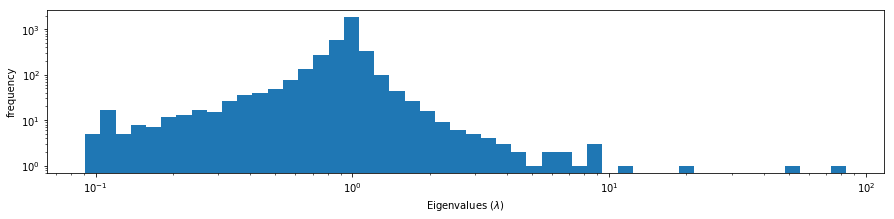

In [19]:
plt.figure(figsize=(15, 3))
plt.yscale('log')
plt.xscale('log')
plt.ylabel("frequency")
plt.xlabel("Eigenvalues ($\lambda$)")
_, bins = np.histogram(np.log10(evals), bins=50)
_ = plt.hist(evals, bins=10**bins)

### Hopfield-Potts model <a id="HopfieldPotts"></a>

This model is a dimension reduction of the Maximum Entropy model. We  call a *pattern* an $L\times q$ matrix $\boldsymbol\xi = \{ \xi_i(a) \}$ where $i = 1, \ldots, L$ being the site indices and $a=1, \ldots, q$ being the amino acids. It is sometimes helpful to think of the pattern as rolled out as a long vector in the same way the double index covariance matrix is converted to a single index covariance matrix. As we will see later, these patterns look very similar to eigenvectors. 

For each pattern we can define a *log-score* of a sequence $(a_1, \ldots, a_L)$ as $$S(a_1, \ldots, a_L | \boldsymbol\xi) = \bigg[ \sum_{i=1}^L \xi_i(a_i) \bigg]^2.$$

Although $S$ has no log in its definition, it is probably called a *log-score* because it is in the exponential part of the probabilty model. We re-write the probability of an amino-acid sequence $(a_1, \ldots, a_L)$ in terms of the log score of the patterns as  $$P(a_1, \ldots, a_L) = \frac{1}{Z} \exp \bigg\{ \frac{1}{2L} \sum_{\mu=1}^{p_+} S(a_1, \ldots, a_L | \xi^{+,\mu}) - \frac{1}{2L} \sum_{\nu=1}^{p_-} S(a_1, \ldots, a_L | \xi^{-,\nu}) + \sum_{i=1}^L h_i(a_i)  \bigg\}$$

This form for the probability distribution corresponds to the following choice of couplings 
$$e_{ij}(a,b) = \frac{1}{L} \sum_{\mu = 1}^{p_+} \xi_i^{+,\mu}(a)\xi_j^{+,\mu}(b) - \frac{1}{L} \sum_{\mu = 1}^{p_-} \xi_i^{-,\nu}(a)\xi_j^{-,\nu}(b) $$

This form of the coupling matrix has rank $p = p_{+} + p_{-}$ and if we choose $p = L(q-1)$ then the coupling matrix has full rank. However, we want to reduce the dimension of the coupling matrix and so we choose $p$ well below that. 

The patterns are determined by Maximum Likelihood inference using Statistical Physics methods but they have an easy to understand relationship with the eigenvalues and eigenvectors of the correlation matrix $\Gamma$. Basically the attractive patterns correspond to the $p_+$ largest eigenvalues $(\lambda_1 \geq \lambda_2 \geq \ldots \geq \lambda_{p_+} \geq 1)$ and the repulsive patterns correspond to the $p_-$ smallest eigenvalues $(\lambda_{L(q-1)} \leq \lambda_{L(q-1) - 1} \leq \ldots \leq \lambda_{L(q-1) + 1 - p} \leq 1)$. If we pick a pattern $\xi$ and its corresponding eigenvalue $\lambda$ and eigenvector $\nu$. Then we have $$\xi_i(a) = \mid 1 - 1/\lambda \mid^{1/2} \tilde{\nu}_{ia}$$ where $$\tilde{\nu}_{ia} = \sum_{b=1}^{q-1} (D_i)^{-1}(a,b) \nu_{jb}$$

We can see that the prefactor $\mid 1 - 1/\lambda \mid^{1/2}$ vanishes for $\lambda = 1$ which is the mean of the eigenvalues. 

Also, from the ML inference we get the contribution of a pattern $\xi$ to the model's log likelihood is a function of its associated eigenvalue $\lambda$ only, $$\Delta \mathcal{L}(\lambda) = \frac{1}{2}(\lambda -1 - \log\lambda).$$

In [20]:
def get_pattern(idx):
    prefactor = np.sqrt(np.abs(1 - 1. / evals[idx]))
    pattern = prefactor * (D_ii_inv @ evecs[:, idx])
    return (pattern)

def expand_pattern_into_three_lines(pattern):
    """ Pattern is a 1-D numpy array of size N"""
    # x is just [0,0,0, 1,1,1, 2,2,2 ... N,N,N ]
    x = np.repeat(np.arange(pattern.shape[0]), 3)

    # for y we are going to interleave [0, p[0], 0, 0, p[1], 0, .... 0, p[N-1], 0
    expand_pattern = np.repeat(pattern, 3).reshape(pattern.shape[0], 3)
    expand_pattern[0, :] = 0
    expand_pattern[2, :] = 0
    y = expand_pattern.flatten(order='F')

    # now x and y are such that it will plot vertical lines from 0 to p for each index
    # the lines go from the x-axis to the pattern and then back to the x-axis
    return (x, y)

def plot_pattern(idx, ax, signif_label_digits=2):
    pattern = get_pattern(idx)
    px, py = expand_pattern_into_three_lines(pattern)
    ax.plot(px/(q-1), py, marker='o', markevery=(1, 3), markersize=2, linewidth=0.3, 
         label=("$\lambda$= {0:." + str(signif_label_digits) + "f}").format(evals[idx]))
    ax.set_xlabel("$i + a/(q-1)$")
    ax.set_ylabel("$\\xi$")
    ax.legend()
    ax.grid(True, axis='x', linestyle='--', alpha=0.4)

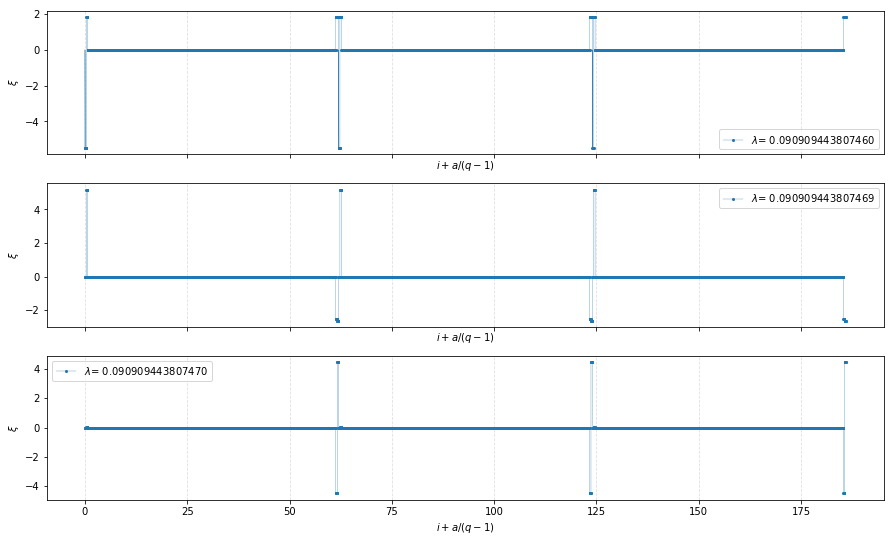

In [21]:
# Repulsive patterns
# plot pattern corresponding to the smallest eigenvalues
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(15, 9))
plot_pattern(0, ax0, signif_label_digits=15)
plot_pattern(1, ax1, signif_label_digits=15)
plot_pattern(2, ax2, signif_label_digits=15)


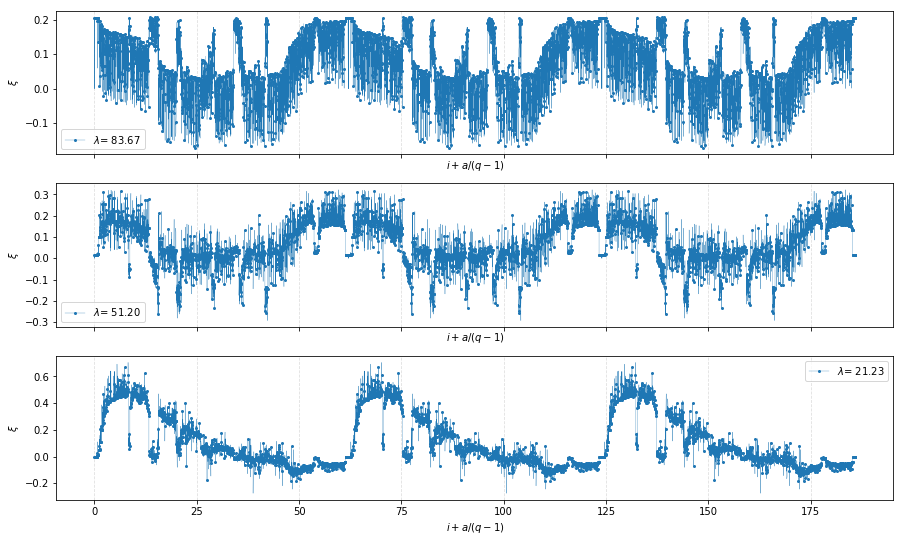

In [22]:
# Attractive patterns
# plot pattern corresponding to the largest eigenvalue
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(15, 9))
plot_pattern(-1, ax0, signif_label_digits=2)
plot_pattern(-2, ax1, signif_label_digits=2)
plot_pattern(-3, ax2, signif_label_digits=2)